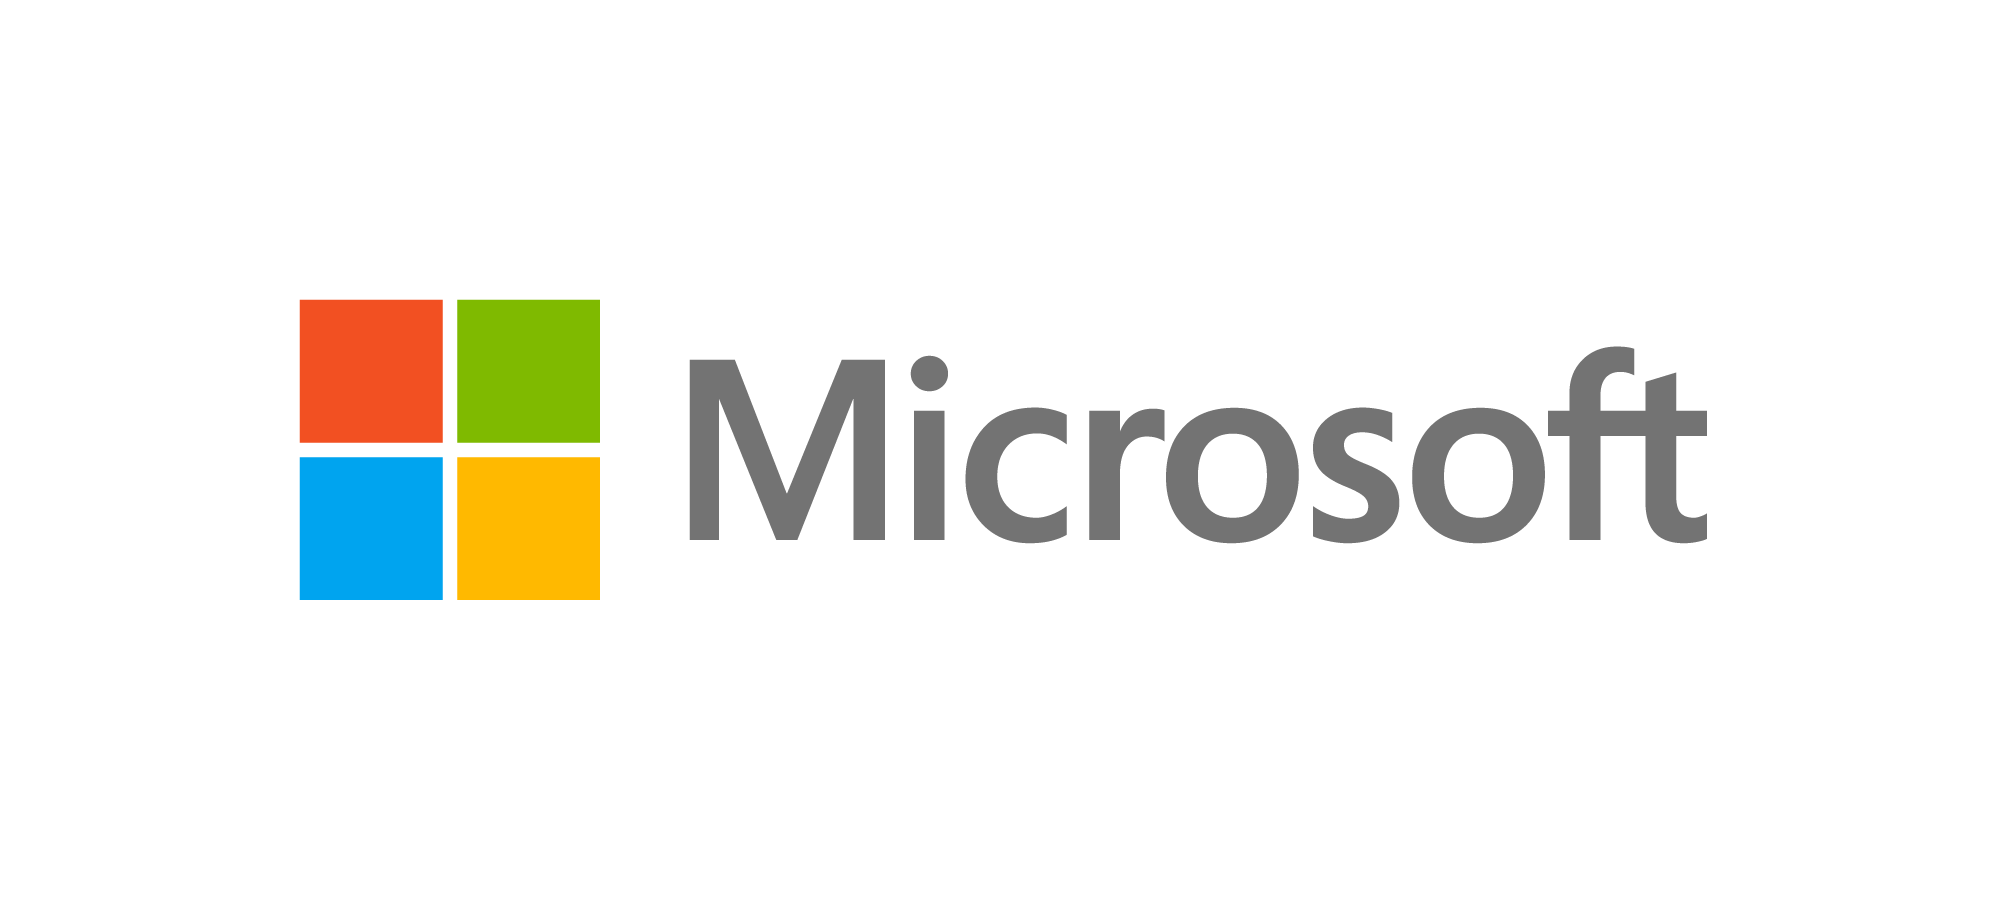

# Microsoft Movie Studios Analysis

**Authors:** Dermot O'Brien, Ziyuan Wang
***

## Overview

We have been tasked with providing the head of "Microsoft Movie Studios" three actionable insights that they can use to decide what kinds of films to make. To make these reccommendations, we must first gather movie data from reputable sources, clean the data properly, and analyze and vizualize our findings simply and effectively.

## Business Problem

Microsoft Movie Studios is a relatively new division that is looking to compete with the best movie makers in the business. To do this, they will first need to have a better understanding of their competitors successes and failures, the trends related to the kinds of movies that are successful, the types of movies that have high production costs and gross profits, etc. In this analysis, we hope to provide a clearer picture of the industry and target an area of focus for Microsoft Movie Studios to take advantage of. 

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

To analyze the movie industry as a whole, we took data from the following sources:
- Box Office Mojo
- Rotten Tomatoes
- The Movie Database (TMDB)
- The Numbers
- Internet Movie Database (IMDB)

These datasets come from reputable sources in the movie industry and include insightful data points like movie ratings, genres, production budgets, gross profits, etc.

In [8]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from collections import defaultdict
from IPython.display import Image
%matplotlib inline

# Create a connection to IMDB Database
conn = sqlite3.connect('./zippedData/im.db')

# JN Display Options
pd.options.display.max_rows = 1000

In [9]:
# Create dataframes from the files

# Box Office Mojo
bom_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

# Rotten Tomatoes Movies
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', delimiter='\t')

# Rotten Tomatoes Reviews
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')

# The Numbers Movie Budgets
tn_moviebudgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

# The Movie Data Base Movies
tmdb_moives_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz') # genre ids?

# IMDB Database (Schema)
imdb_schema = pd.read_sql("""
SELECT *
FROM sqlite_master
""", conn)

## Data Preparation

Each dataset had unique properties and needed to be prepared depending on it's individual needs and the type of analysis we planned to perform.

For the Rotten Tomatoes data, we decided to merge the movies and reviews tables into a new dataframe called rt_full_df. Using an inner join, this new dataframe includes only movies from both tables, and allowes us to analyze ratings of different movie genres.


***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### Rotten Tomatoes Data Inspection, Preparation, and Analysis

##### Rotten Tomatoes Movies

In [64]:
rt_movie_df.head(3)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN


##### Rotten Tomatoes Reviews

In [63]:
rt_reviews_df.head(3)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


##### Merge the Rotten Tomatoes Dataframes

In [55]:
# Merge the dataframes using an inner join
rt_full_df = rt_movie_df.merge(rt_reviews_df, how='inner', on='id')
rt_full_df.head(3)

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


##### Best Genre's according to top critics "fresh" ratings

The "Fresh" column is used by a critic to indicate, on a binary scale, whether the movie was good (fresh) or bad (rotten). To use this data for analysis, we took the sum of the "fresh" ratings for a given movie divided by the total ratings in the fresh column, the sum of "fresh" and "rotten" ratings, to derive a value we called "Fresh Rating" for each movie. Using this new value, we took the average "Fresh Rating" per genre to see which genres were most enjoyed by rotten tomato users.

In [5]:
# Create a dictionary with k = movie id and v = fresh/total ratio of all "fresh" ratings by critics per movie
movie_fresh_dict = {} 
for movie_id in rt_full_df.groupby(by='id').groups:
    count = rt_full_df.groupby(by='id').get_group(movie_id)['fresh'].value_counts().values.tolist()
    total_count = sum(count)
    if total_count >= 100:
        try:
            ratio = round(count[0] / (count[0] + count[1]), 2)
        except:
            ratio = 1
    else:
        continue
    
    movie_fresh_dict[movie_id] = ratio
#movie_fresh_dict

In [6]:
# Filter out rows that have less than 100 fresh ratings, to keep only signficant ratings
genre_clean = rt_full_df.groupby(by='id').count()
genre_clean = genre_clean.loc[genre_clean['fresh'] > 100]
genre_index_100 = list(genre_clean.index)
genre_df = rt_full_df.loc[rt_full_df['id'].isin(genre_index_100)]

# Create a dictionary where k = movie id and v = genre
genre_dict = dict(zip(genre_df.id, genre_df.genre))
#genre_dict

In [8]:
# Create a dictionary where k = movie id and v = list that includes the fresh rating and genre
genre_rating_dict = {}

for key in (movie_fresh_dict.keys() | genre_dict.keys()):
    if key in movie_fresh_dict: 
        genre_rating_dict.setdefault(key, []).append(movie_fresh_dict[key])
    if key in genre_dict: 
        genre_rating_dict.setdefault(key, []).append(genre_dict[key])
#genre_rating_dict

In [68]:
# Create a dataframe that includes movie id (as index), Fresh Ratio, Genre
genre_rating_df = pd.DataFrame.from_dict(genre_rating_dict, orient='index', columns=['Fresh Ratio', 'Genre']).sort_values(by='Fresh Ratio', ascending=False)
genre_rating_df['Main Genre'] = genre_rating_df['Genre'].str.split("|").str[0]
#genre_rating_df

In [69]:
# Group dataframe by Genre and find the average fresh ratio for each genre
genre_rating_df = genre_rating_df.groupby(by='Main Genre').mean().sort_values(by='Fresh Ratio', ascending=False).reset_index()

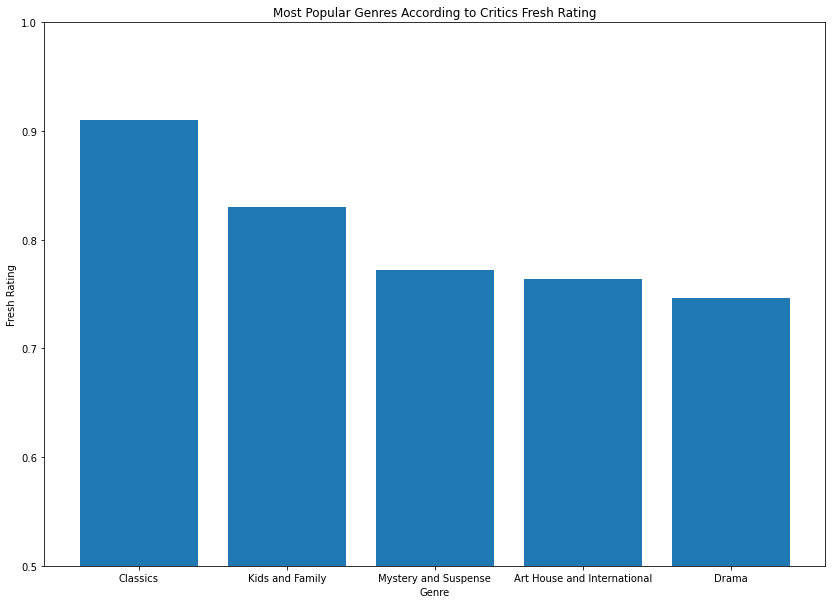

In [71]:
# Create a bar chart
genre_x = genre_rating_df['Main Genre'].head()
rating_y = genre_rating_df['Fresh Ratio'].head()

fig, ax = plt.subplots(figsize = (14,10))

ax.set_ylim(.5, 1)
ax.bar(genre_x, rating_y)
ax.set_xlabel('Genre')
ax.set_ylabel('Fresh Rating')
ax.set_title('Most Popular Genres According to Critics Fresh Rating');

According to rotten tomatoes users, the top 5 genres according to the fresh scale are Classics, Kids and Family, Mystery and Suspense, Arthouse, and Drama.

### IMDB Data Inspection, Preparation, and Analysis

##### Best Runtimes according to IMDB ratings
Using the IMDB database, we wanted to know what the typical runtimes are for movies with high ratings (defined by a movie having an average rating greater than or equal to 7). To prepare the data, we inner joined the movie_basics and movie_ratings tables on movie_id. We then set two conditions: that the number of votes is greater than 10,000 and that the average rating is greater than or equal to a 7. We distinguished that only ratings with greater than 10,000 votes were significant enough to display. See our preparation and analysis below:

In [77]:
# Create a dataframe to analysze runtimes
runtime_df = pd.read_sql("""
SELECT *
FROM
    movie_basics as mb
    INNER JOIN movie_ratings as mr
        USING(movie_id)
WHERE numvotes > 10000 and averagerating >= 7.0 -- chose 10,000 so the ratings were significant, less significant the smaller the vote count
ORDER BY averagerating ASC
""", conn)

In [78]:
# Drop movies that aggregate mutiple parts. The movies below were either docuseries with multiple episodes aggregated 
# or had Part1/Part2 combined into one runtime
runtime_df.loc[runtime_df['runtime_minutes'] > 200]
runtime_df.drop([174, 904, 972], inplace=True)

In [79]:
# Check the min and max runtimes in order to create a range for the histogram bins
runtime_df['runtime_minutes'].describe()

count    974.000000
mean     118.239220
std       21.534772
min       45.000000
25%      102.000000
50%      116.000000
75%      132.000000
max      196.000000
Name: runtime_minutes, dtype: float64

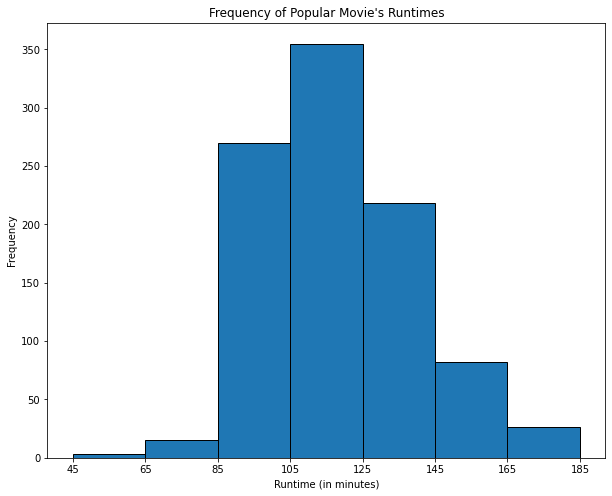

In [80]:
# Create a histogram to show frequencies of popular movie's runtimes
x = runtime_df['runtime_minutes']
bin_names = ["45-65","65-85", "85-105", "105-125", "125-145", "145-165", "165-195"]

fig, ax = plt.subplots(figsize=(10,8))

ax.hist(x, bins=range(45, 195, 20), edgecolor='black')
ax.set_xlabel('Runtime (in minutes)')
ax.set_ylabel('Frequency')
ax.set_title("Frequency of Popular Movie's Runtimes")
ax.set_xticks(range(45, 195, 20));
#ax.set_xticklabels(bin_names, rotation=45);

As shown above, the most frequent length of a popular movie fall between 105 and 125 minutes. 

##### Best genre according to IMDB

In this analysis, we wanted to see what the highest rated genres were in IMDB's database. To prepare the data, we inner joined the movie_basics and movie_ratings tables on movie_id and only looked at movies with votes greater than 10,000 (to keep the rating value significant). See our preparation and analysis below:

In [127]:
# Create a dataframe, limit min numvotes to get significant ratings
imdb_genre_df = pd.read_sql("""
SELECT *
FROM
    movie_basics as mb
    INNER JOIN movie_ratings as mr
        USING(movie_id)
WHERE numvotes > 10000
""", conn)

In [128]:
# Extract the primary genre from the list of genres per movie
imdb_genre_df['main_genre'] = imdb_genre_df['genres'].str.split(",").str[0]

In [129]:
# Group by genre and find the average rating per genre using median
imdb_pop_genre_df = imdb_genre_df.groupby(by='main_genre').median().sort_values(by='averagerating', ascending=False).reset_index()

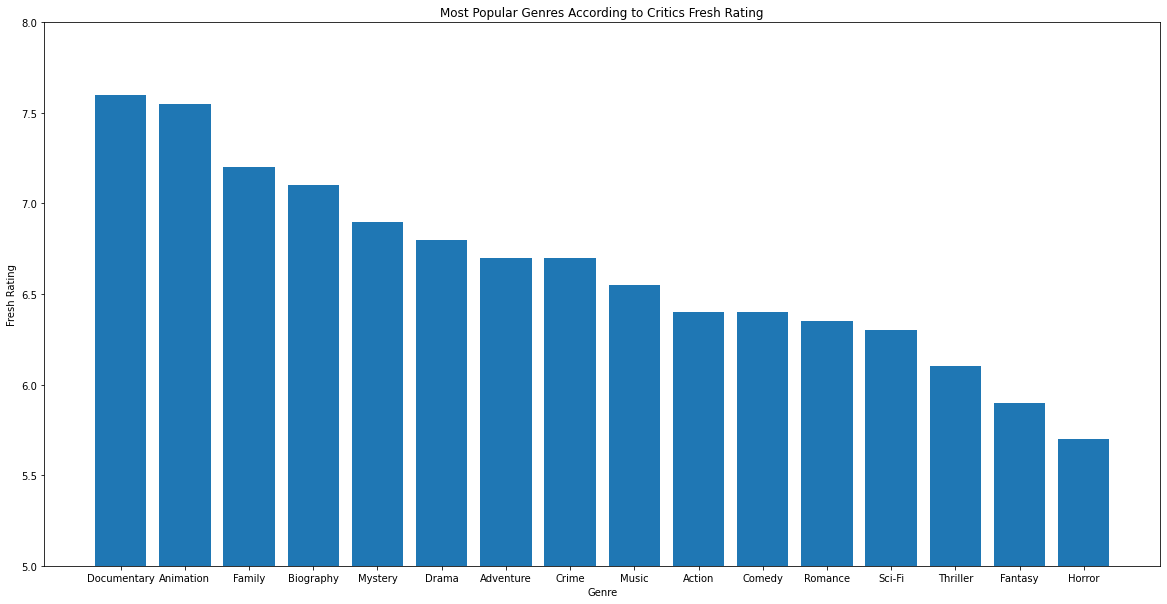

In [130]:
# Create a bar chart
imdb_genre_x = imdb_pop_genre_df['main_genre']
imdb_rating_y = imdb_pop_genre_df['averagerating']

fig, ax = plt.subplots(figsize = (20,10))


ax.bar(imdb_genre_x, imdb_rating_y)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Most Popular Genres According to IMDB Ratings')
ax.set_ylim(5, 8);

As shown, Documentary, Animation, Family are the highest rated genre's in IMDB's database. Note that we took the median rating per genre.

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***